# DNN based Wind Power Forecasting

In [1]:
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.vector_ar.var_model import VAR
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
def custom_date_parser(x): return datetime.strptime(x, "%Y %m %d %H")


def load_data(col=None, path="kayathar", verbose=False):
    df = pd.DataFrame()
    files = ['Apr 10','Jun 10','Jul 10','Aug 10','Sep 10','Oct 10','Nov 10', 'Dec 10','Jan 11', 'Feb 11', 'Mar 11']
    # files = ['Apr 10','Jun 10']
    for _file in files:
        df = df.append(pd.read_table(path+'/'+_file+'.txt'))

    df.drop(columns=df.columns.difference(col), inplace=True)
    df = df.rename(columns={'CH1Avg': 'Wind Speed 70m', 'CH2Avg': 'Wind Speed 50m','CH7Avg': 'Direction 70m', 'CH8Avg': 'Direction 50m'})
    print(len(df))
    print(len(df.dropna()))
    df = df.dropna()
    if verbose:
        df.head()
    return df


In [3]:
print("Multivariate Sample")
multivar_df = load_data(['CH1Avg', 'CH2Avg', 'CH7Avg', 'CH8Avg'],path='kayathar', verbose=True)
# final_table_columns = ['Date', 'Time',
#                        'CH1Avg ', 'CH2Avg ', 'CH7Avg', 'CH8Avg']
# multivar_df.drop(columns=multivar_df.columns.difference(
#     final_table_columns), inplace=True)

# multivar_df['TimeStamp'] = pd.to_datetime()
multivar_df


Multivariate Sample
47996
39645


/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

,Direction 70m,Direction 50m,Wind Speed 70m,Wind Speed 50m
0,222,281,6.2,5.9
1,223,282,6.7,6.3
2,223,281,7.2,6.6
3,223,282,7.4,6.9
4,221,278,7.9,7.4
...,...,...,...,...
4458,277,279,1.2,1.1
4459,290,295,2.4,2.0
4460,300,303,2.0,1.5
4461,290,293,2.9,2.5


In [4]:
def correlation_plot(df):
    corr = df.corr()
    corr.style.background_gradient(cmap='coolwarm')


def actual_predicted_plot(actual, predicted, xlabel='Time in Hours', ylabel='Wind Speed'):
    plt.figure(figsize=(16, 9))
    plt.title('Actual Vs Predicted')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.plot(actual)
    plt.plot(predicted)
    plt.legend(('Actual', 'predicted'))


def month_wise_plot(df, target_col):
    fig, axs = plt.subplots(figsize=(12, 4))
    df.groupby(df.index.month)[
        'WindSpeed 50'].mean().plot(kind='bar', rot=0, ax=axs)
    plt.xlabel("Months")
    plt.ylabel(target_col)
    plt.show()


def clean_data(series):
    """Fills missing values. 

        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')

    return series_filled


def min_max_scale(dataframe):
    """ Applies MinMax Scaling

        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)


def split_data(series, train_freq, test_len=1008, enable_test=False):

    test_slice = len(series)-test_len
    test_data = series[test_slice:]
    if enable_test:
        train_val_data = series[:test_slice]
    else:
        train_val_data = series

    # make train and validation from the remaining
    train_size = int(len(train_val_data) * train_freq)

    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    return train_data, val_data, test_data


In [5]:
multivar_df = clean_data(multivar_df)
multivar_df_scaled = min_max_scale(multivar_df)
train_multi, val_multi, test_multi = split_data(
    multivar_df_scaled, train_freq=0.65, test_len=8760)
print("Multivarate Datasets")
print(f"Dataset Shape: {multivar_df_scaled.shape}")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")


Multivarate Datasets
Dataset Shape: (39645, 4)
Train Data Shape: (25769, 4)
Val Data Shape: (13876, 4)
Test Data Shape: (8760, 4)


In [6]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False):
    """ Create a windowed tensorflow dataset

    """
    # create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon

    ds = tf.data.Dataset.from_tensor_slices(data)

    # create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)

    # flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x: x.batch(window))
    ds = ds.shuffle(shuffle_buffer)

    # create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x: (x[:-n_horizon], x[-n_horizon:, 1:2]))
    else:
        ds = ds.map(lambda x: (x[:-n_horizon], x[-n_horizon:]))

    ds = ds.batch(batch_size).prefetch(1)

    return ds

# tf.random.set_seed(42)


n_steps = 72
n_horizon = 24
batch_size = 1
shuffle_buffer = 100


ds = window_dataset(train_multi, n_steps, n_horizon,
                    batch_size, shuffle_buffer, multi_var=True)

print('Example sample shapes')
for idx, (x, y) in enumerate(ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Example sample shapes
x =  (1, 72, 4)
y =  (1, 24, 1)


2022-06-20 01:05:39.543806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-20 01:05:39.543884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-20 01:05:39.582570: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
def build_dataset(train_freq=0.7,
                  n_steps=24*30,
                  n_horizon=24,
                  batch_size=100,
                  shuffle_buffer=500,
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """

    # tf.random.set_seed(23)

    if multi_var:
        data = load_data(['CH1Avg', 'CH2Avg', 'CH7Avg', 'CH8Avg'],path='kayathar', verbose=True)
    else:
        data = load_data(['CH1Avg'],path='kayathar', verbose=True)

    data = clean_data(data)

    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)

    train_data, val_data, test_data = split_data(
        data, train_freq=train_freq, test_len=8760, enable_test=False)

    train_ds = window_dataset(
        train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var)
    val_ds = window_dataset(val_data, n_steps, n_horizon,
                            batch_size, shuffle_buffer, multi_var=multi_var)
    test_ds = window_dataset(
        test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var)

    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)

    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = build_dataset(multi_var=True)


/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

47996
39645
Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


In [8]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps = 24*30
    n_horizon = 24
    if multivar:
        n_features = multivar_df.shape[1]
    else:
        n_features = 1

    return n_steps, n_horizon, n_features, lr


model_configs = dict()


def cfg_model_run(model, history, test_ds):
    return {"model": model, "history": history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):

    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(
        n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds


### Dense NN model

In [9]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(loss=loss, optimizer='adam', metrics=[
                  'mae', tf.keras.metrics.RootMeanSquaredError()])

    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()


Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2880)              0         
                                                                 
 dense (Dense)               (None, 128)               368768    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 388,376
Trainable params: 388,376
Non-trainable p

### CNN model

In [10]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):

    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(
            64, kernel_size=6, activation='relu', input_shape=(n_steps, n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")

    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(loss=loss, optimizer='adam', metrics=[
                  'mae', tf.keras.metrics.RootMeanSquaredError()])

    return model


cnn = cnn_model(*get_params(multivar=True))
cnn.summary()


Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1600      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 11328)             0         
                                                                 
 dropout (Dropout)           (None, 11328)             0       

### LSTM model

In [11]:
def lstm_model(n_steps, n_horizon, n_features, lr):

    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(
            n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='stacked_lstm')

    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(loss=loss, optimizer='adam', metrics=[
                  'mae', tf.keras.metrics.RootMeanSquaredError()])

    return model


lstm = lstm_model(*get_params(multivar=True))
lstm.summary()


Model: "stacked_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 72)           22176     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)               

### CNN-LSTM model

In [12]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):

    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(
            64, kernel_size=6, activation='relu', input_shape=(n_steps, n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")

    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(loss=loss, optimizer='adam', metrics=[
                  'mae', tf.keras.metrics.RootMeanSquaredError()])

    return model


lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()


Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1600      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 177, 72)           39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

### CNN-LSTM skip model

In [13]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):

    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input(shape=(n_steps, n_features), name='main')

    conv1 = tf.keras.layers.Conv1D(
        64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(
        64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(
        72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(
        48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)

    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)

    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')

    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(loss=loss, optimizer='adam', metrics=[
                  'mae', tf.keras.metrics.RootMeanSquaredError()])

    return model


lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()


Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 720, 4)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 715, 64)      1600        ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 357, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 355, 64)      12352       ['max_pooling1d[0][0]']          
                                                                                          

### Vanilla LSTM

In [14]:
def vanilla_lstm_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.LSTM(200, input_shape=(n_steps, n_features)),
            tf.keras.layers.Dense(48, activation="sigmoid"),
            tf.keras.layers.Dense(48, activation="tanh"),
            tf.keras.layers.Dense(24, activation="sigmoid"),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(units=n_horizon),
        ],)

    loss = tf.keras.losses.Huber()
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(loss=loss, optimizer='adam', metrics=[
                  'mae', tf.keras.metrics.RootMeanSquaredError()])

    return model


vanilla_lstm = vanilla_lstm_model(*get_params(multivar=True))
vanilla_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               164000    
                                                                 
 dense (Dense)               (None, 48)                9648      
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 24)                1176      
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
Total params: 177,776
Trainable params: 177,776
Non-trai

In [15]:
run_model("dnn", dnn_model, model_configs, epochs=10)


/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

47996
39645
Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/10


/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
2022-06-20 01:05:41.246112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 38ms/step - loss: 0.2063 - mae: 0.5121 - root_mean_squared_error: 0.6825 - val_loss: 0.0556 - val_mae: 0.2409 - val_root_mean_squared_error: 0.3336
Epoch 2/10


2022-06-20 01:05:41.775262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 33ms/step - loss: 0.0705 - mae: 0.3026 - root_mean_squared_error: 0.3756 - val_loss: 0.0512 - val_mae: 0.2325 - val_root_mean_squared_error: 0.3200
Epoch 3/10
12/12 [==============================] - 1s 35ms/step - loss: 0.0512 - mae: 0.2585 - root_mean_squared_error: 0.3201 - val_loss: 0.0484 - val_mae: 0.2362 - val_root_mean_squared_error: 0.3111
Epoch 4/10
12/12 [==============================] - 1s 33ms/step - loss: 0.0412 - mae: 0.2294 - root_mean_squared_error: 0.2871 - val_loss: 0.0474 - val_mae: 0.2365 - val_root_mean_squared_error: 0.3079
Epoch 5/10
12/12 [==============================] - 1s 33ms/step - loss: 0.0370 - mae: 0.2157 - root_mean_squared_error: 0.2721 - val_loss: 0.0465 - val_mae: 0.2400 - val_root_mean_squared_error: 0.3048
Epoch 6/10
12/12 [==============================] - 1s 32ms/step - loss: 0.0339 - mae: 0.2052 - root_mean_squared_error: 0.2602 - val_loss: 0.0462 - val_mae: 0.2407 - val_root_mean_squared_error: 0.3

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [16]:
run_model("cnn", cnn_model, model_configs, epochs=10)


/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

47996
39645
Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/10


2022-06-20 01:05:47.533444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     12/Unknown - 1s 22ms/step - loss: 0.1354 - mae: 0.4248 - root_mean_squared_error: 0.5302

2022-06-20 01:05:48.131622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 49ms/step - loss: 0.1354 - mae: 0.4248 - root_mean_squared_error: 0.5302 - val_loss: 0.0687 - val_mae: 0.3302 - val_root_mean_squared_error: 0.3708
Epoch 2/10
12/12 [==============================] - 1s 42ms/step - loss: 0.0454 - mae: 0.2430 - root_mean_squared_error: 0.3015 - val_loss: 0.0513 - val_mae: 0.2763 - val_root_mean_squared_error: 0.3202
Epoch 3/10
12/12 [==============================] - 1s 43ms/step - loss: 0.0346 - mae: 0.2078 - root_mean_squared_error: 0.2632 - val_loss: 0.0488 - val_mae: 0.2460 - val_root_mean_squared_error: 0.3125
Epoch 4/10
12/12 [==============================] - 1s 44ms/step - loss: 0.0284 - mae: 0.1842 - root_mean_squared_error: 0.2381 - val_loss: 0.0492 - val_mae: 0.2506 - val_root_mean_squared_error: 0.3136
Epoch 5/10
12/12 [==============================] - 1s 45ms/step - loss: 0.0249 - mae: 0.1711 - root_mean_squared_error: 0.2232 - val_loss: 0.0498 - val_mae: 0.2443 - val_root_mean_squared_error: 0.3

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [17]:
run_model("vanilla_lstm", vanilla_lstm_model, model_configs, epochs=10)


/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

47996
39645
Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/10


2022-06-20 01:05:55.757672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 01:05:56.052164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 01:05:58.106201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     12/Unknown - 23s 1s/step - loss: 0.1854 - mae: 0.5172 - root_mean_squared_error: 0.6126   

2022-06-20 01:06:17.896093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 01:06:18.064279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 27s 2s/step - loss: 0.1854 - mae: 0.5172 - root_mean_squared_error: 0.6126 - val_loss: 0.0758 - val_mae: 0.3121 - val_root_mean_squared_error: 0.3894
Epoch 2/10
12/12 [==============================] - 7s 528ms/step - loss: 0.1009 - mae: 0.3672 - root_mean_squared_error: 0.4497 - val_loss: 0.0754 - val_mae: 0.3511 - val_root_mean_squared_error: 0.3882
Epoch 3/10
12/12 [==============================] - 6s 483ms/step - loss: 0.0759 - mae: 0.3124 - root_mean_squared_error: 0.3896 - val_loss: 0.0771 - val_mae: 0.3671 - val_root_mean_squared_error: 0.3928
Epoch 4/10
12/12 [==============================] - 6s 475ms/step - loss: 0.0658 - mae: 0.2876 - root_mean_squared_error: 0.3629 - val_loss: 0.0801 - val_mae: 0.3786 - val_root_mean_squared_error: 0.4001
Epoch 5/10
12/12 [==============================] - 6s 473ms/step - loss: 0.0603 - mae: 0.2731 - root_mean_squared_error: 0.3472 - val_loss: 0.0818 - val_mae: 0.3845 - val_root_mean_squared_error: 

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [18]:
# run_model("stacked_lstm", lstm_model, model_configs, epochs=10)


In [19]:
# run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=10)


In [20]:
# run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=10)


### Losses Plot

Loss Curves


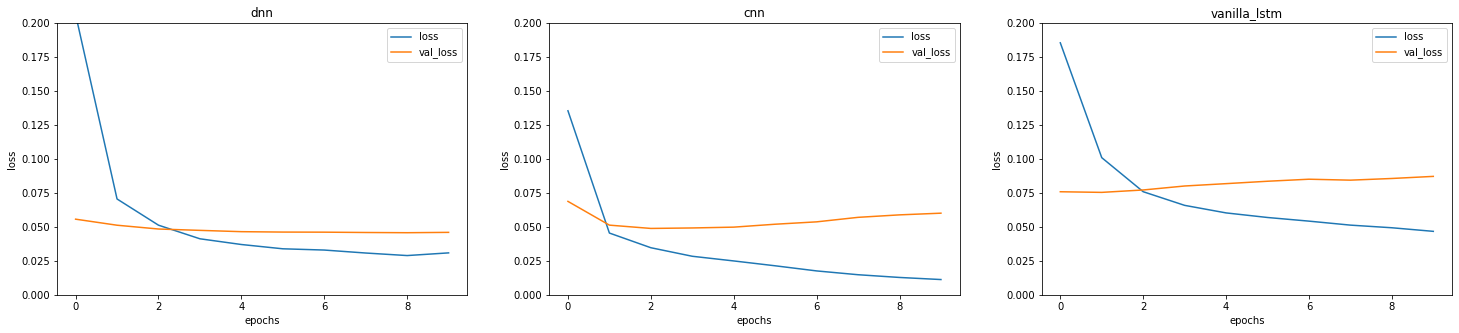

In [21]:
legend = list()

fig, axs = plt.subplots(1, len(model_configs.items()), figsize=(25, 5))


def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])


for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")


MAE Curves


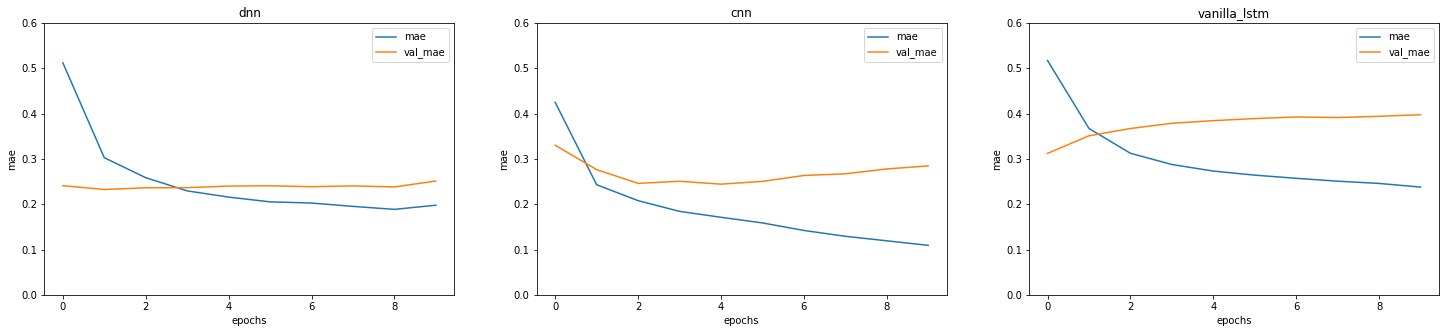

In [22]:
print("MAE Curves")
fig, axs = plt.subplots(1, len(model_configs.items()), figsize=(25, 5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)


### Performance Plot

In [24]:
names = list()
performance_dict = {'mae': [], 'rmse': []}


for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance_dict['mae'].append(mae[1])
    performance_dict['rmse'].append(mae[2])

performance_df = pd.DataFrame(
    data=performance_dict, columns=performance_dict.keys(), index=names)
performance_df['Error in M/S'] = performance_df['mae'] * \
    load_data(['CH1Avg'], verbose=False).mean().values
print(performance_df)


4/4 [==============================] - 1s 155ms/step - loss: 0.0797 - mae: 0.3764 - root_mean_squared_error: 0.3993
47996
43676
                   mae      rmse  Error in M/S
dnn           0.240734  0.289103      1.466660
cnn           0.280103  0.339069      1.706517
vanilla_lstm  0.376386  0.399348      2.293118


/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_table(path+'/'+_file+'.txt'))
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/3818448102.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

### Prediction Plot

In [25]:
def performance_metrics(data, y_true, y_pred, days=2):
    data['mae'].append(mean_absolute_error(
        y_true.numpy()[:days].reshape(-1), y_pred[:days].reshape(-1)))
    data['mse'].append(mean_squared_error(
        y_true.numpy()[:days].reshape(-1), y_pred[:days].reshape(-1)))
    data['rmse'].append(np.sqrt(mean_squared_error(
        y_true.numpy()[:days].reshape(-1), y_pred[:days].reshape(-1))))
    data['mape'].append(np.mean(np.abs((y_true.numpy()[:days].reshape(-1) -
                        y_pred[:days].reshape(-1)) / y_true.numpy()[:days].reshape(-1))) * 100)
    return data


2022-06-20 01:12:37.543929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 01:12:37.704457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 01:12:38.037186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 01:12:38.166195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


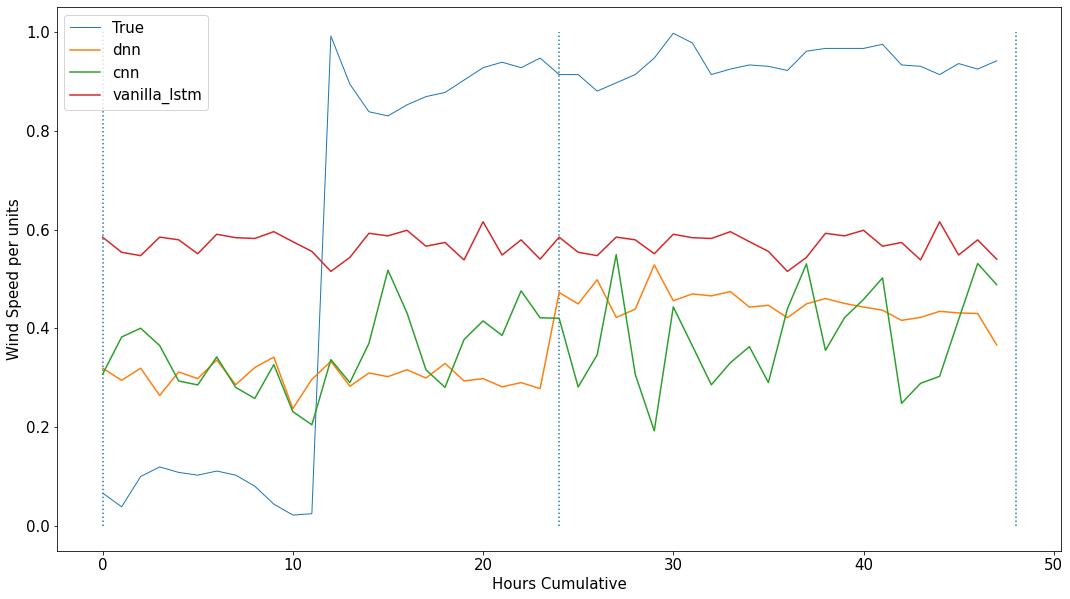

In [26]:
days = 2
wind_speed_data = pd.DataFrame({'True': []})

plt.figure(figsize=(18, 10))
test_data = model_configs['dnn']['test_ds']
_, ybatch = iter(test_data).get_next()
wind_speed_data['True'] = ybatch.numpy()[:days].reshape(-1)
vline = np.linspace(0, days*24, days+1)
plt.plot(ybatch.numpy()[:days].reshape(-1), label="True", linewidth='1')
plt.vlines(vline, ymin=0, ymax=1, linestyle='dotted')
for key, val in model_configs.items():
    preds = val['model'].predict(test_data)
    wind_speed_data = pd.concat([wind_speed_data, pd.Series(
        preds[:days].reshape(-1)).rename(key)], axis=1)

    plt.plot(preds[:days].reshape(-1), label=key)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel("Hours Cumulative", fontsize=15)
    plt.ylabel("Wind Speed per units", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)


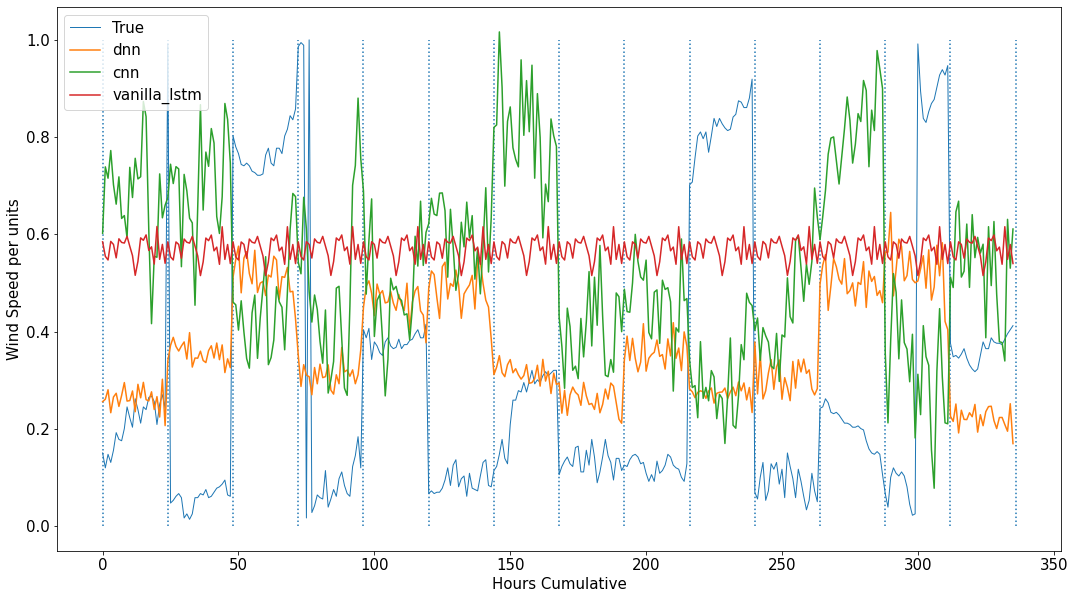

In [27]:
days = 14
wind_speed_data = pd.DataFrame({'True': []})

plt.figure(figsize=(18, 10))
test_data = model_configs['dnn']['test_ds']
_, ybatch = iter(test_data).get_next()
wind_speed_data['True'] = ybatch.numpy()[:days].reshape(-1)
vline = np.linspace(0, days*24, days+1)
plt.plot(ybatch.numpy()[:days].reshape(-1), label="True", linewidth='1')
plt.vlines(vline, ymin=0, ymax=1, linestyle='dotted')
for key, val in model_configs.items():
    preds = val['model'].predict(test_data)
    wind_speed_data = pd.concat([wind_speed_data, pd.Series(
        preds[:days].reshape(-1)).rename(key)], axis=1)

    plt.plot(preds[:days].reshape(-1), label=key)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel("Hours Cumulative", fontsize=15)
    plt.ylabel("Wind Speed per units", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)


In [28]:
wind_speed_data.head(10).style

,True,dnn,cnn,vanilla_lstm
0,0.150418,0.255922,0.602147,0.584590
1,0.119777,0.260887,0.738804,0.554774
2,0.147632,0.280373,0.715461,0.547294
3,0.130919,0.233133,0.772327,0.585500
4,0.155989,0.265452,0.702071,0.579240
5,0.192201,0.273161,0.662084,0.551619
6,0.178273,0.246083,0.718239,0.590853
7,0.175487,0.268795,0.632781,0.583363
8,0.200557,0.295168,0.638595,0.582075
9,0.245125,0.257076,0.592510,0.595930


/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/1196353260.py:8: RuntimeWarning: divide by zero encountered in true_divide
  data['mape'].append(np.mean(np.abs((y_true.numpy()[:days].reshape(-1) -
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/1196353260.py:8: RuntimeWarning: divide by zero encountered in true_divide
  data['mape'].append(np.mean(np.abs((y_true.numpy()[:days].reshape(-1) -
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/1196353260.py:8: RuntimeWarning: divide by zero encountered in true_divide
  data['mape'].append(np.mean(np.abs((y_true.numpy()[:days].reshape(-1) -


,mae,rmse,mse,mape
dnn,0.324138,0.381391,0.145459,inf
cnn,0.327523,0.373371,0.139406,inf
vanilla_lstm,0.389454,0.412046,0.169782,inf


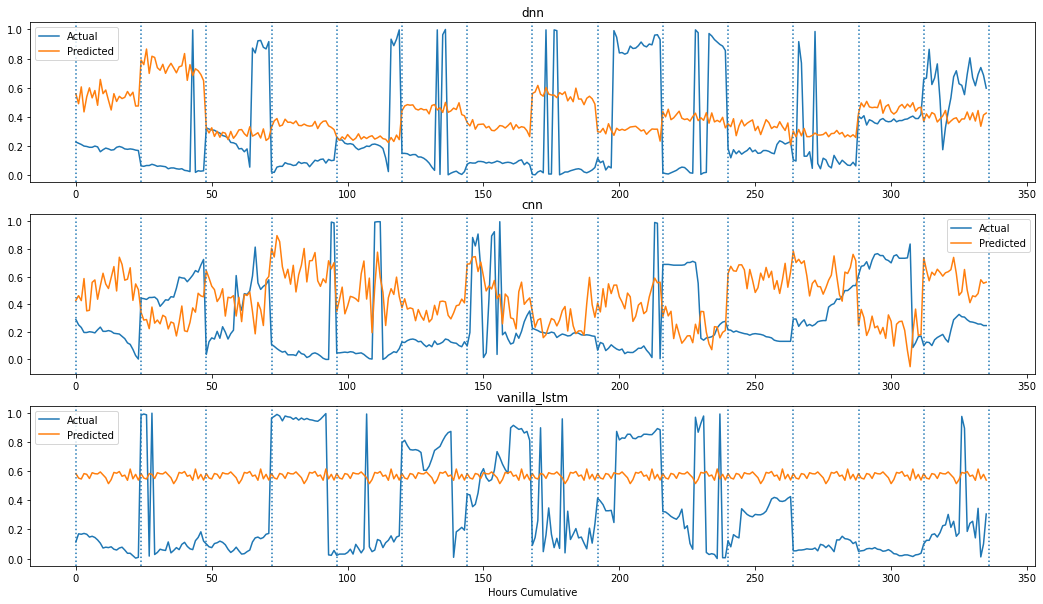

In [29]:
days = 14
perf_dict = {'mae': [], 'rmse': [], 'mse': [], 'mape': []}
_, axs = plt.subplots(len(model_configs.items()), 1, figsize=(18, 10))
for (key, val), ax in zip(model_configs.items(), axs):
    test = val['test_ds']
    preds = val['model'].predict(test)
    _, ybatch = iter(test).get_next()
    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted',
              transform=ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

    perf_dict = performance_metrics(perf_dict, ybatch, preds, days=days)
plt.xlabel("Hours Cumulative")
perf_df = pd.DataFrame(data=perf_dict, columns=perf_dict.keys(), index=names)
perf_df.style


/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_70978/1196353260.py:8: RuntimeWarning: divide by zero encountered in true_divide
  data['mape'].append(np.mean(np.abs((y_true.numpy()[:days].reshape(-1) -


,mae,rmse,mse,mape
dnn,0.265777,0.289715,0.083935,345.350857
cnn,0.366735,0.435321,0.189504,inf
vanilla_lstm,0.394456,0.428860,0.183921,3916.864869


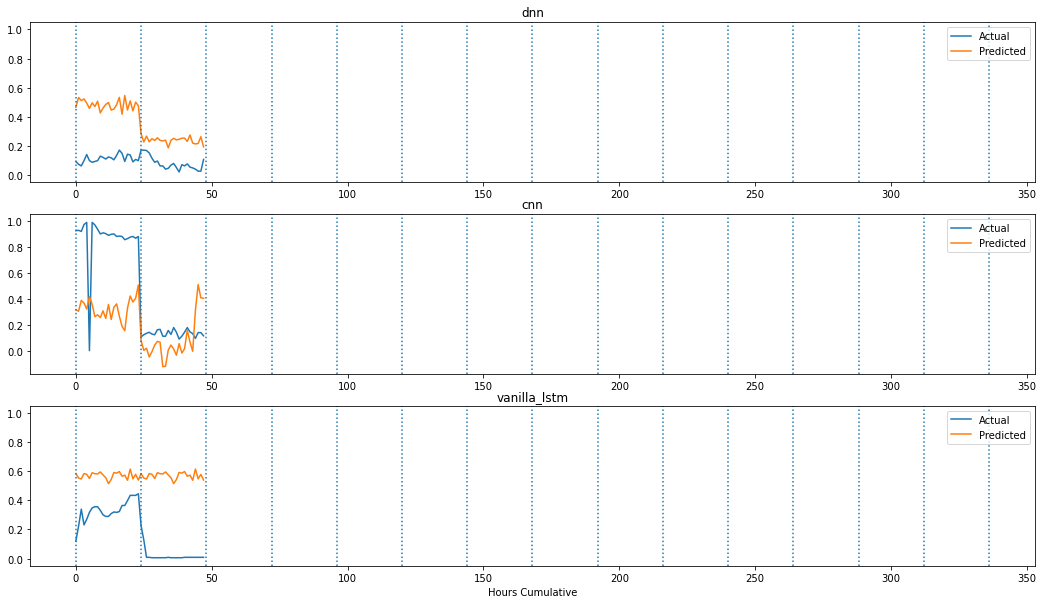

In [30]:
days = 2
perf_dict = {'mae': [], 'rmse': [], 'mse': [], 'mape': []}
_, axs = plt.subplots(len(model_configs.items()), 1, figsize=(18, 10))
for (key, val), ax in zip(model_configs.items(), axs):
    test = val['test_ds']
    preds = val['model'].predict(test)
    _, ybatch = iter(test).get_next()
    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted',
              transform=ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

    perf_dict = performance_metrics(perf_dict, ybatch, preds, days=days)
plt.xlabel("Hours Cumulative")
perf_df = pd.DataFrame(data=perf_dict, columns=perf_dict.keys(), index=names)
perf_df.style


In [31]:
# lstmskip, cnn
# lstm, dnn
def ensemble_model(model_configs, count=2):
    ensemble_model_list = [
        ['lstm_skip', 'stacked_lstm'],
        ['stacked_lstm', 'lstm_cnn']
    ]
    perf_dict = {'mae': [], 'rmse': [], 'mse': [], 'mape': []}
    test_model = model_configs['dnn']['test_ds']
    _, y_true = iter(test_model).get_next()

    for i in ensemble_model_list:
        pred_model1 = model_configs[i[0]]['model'].predict(test_model)
        pred_model2 = model_configs[i[1]]['model'].predict(test_model)
        ensemble_pred = (pred_model1+pred_model2) / 2
        perf_dict = performance_metrics(
            perf_dict, y_true, ensemble_pred, days=count)
        actual_predicted_plot(
            y_true.numpy()[:count].reshape(-1),  ensemble_pred[:count].reshape(-1))
    perf_df = pd.DataFrame(data=perf_dict, columns=perf_dict.keys(), index=[
                           'LSTM-skip and stacked-LSTM', 'Stacked-LSTM and LSTM-CNN'])
    return perf_df


In [32]:
print('Ensemble model Plot')
ensemble_perf = ensemble_model(model_configs, count=3)
ensemble_perf.style


Ensemble model Plot


KeyError: 'lstm_skip'

In [ ]:
def ensemble_model_combined_graph(model_configs, count=2):
    ensemble_model_list = [
        ['lstm_skip', 'stacked_lstm'],
        ['stacked_lstm', 'lstm_cnn']
    ]
    perf_dict = {'mae': [], 'rmse': [], 'mse': [], 'mape': []}
    plt.figure(figsize=(18, 10))
    test_model = model_configs['dnn']['test_ds']
    _, y_true = iter(test_model).get_next()
    plt.plot(y_true.numpy()[:count].reshape(-1), label="True", linewidth='1')
    plt.vlines(np.linspace(0, count*24, count+1),
               ymin=0, ymax=1, linestyle='dotted')

    for i in ensemble_model_list:
        pred_model1 = model_configs[i[0]]['model'].predict(test_model)
        pred_model2 = model_configs[i[1]]['model'].predict(test_model)
        ensemble_pred = (pred_model1+pred_model2) / 2
        plt.plot(ensemble_pred[:count].reshape(-1), label=','.join(i))
        plt.legend(loc='upper left', fontsize=15)


ensemble_model_combined_graph(model_configs, count=3)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0f09a2a5-4e9a-4069-8e2b-17fa808f5770' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>